# Trabalho 2 - Rede SOM

Nome: Harrison Caetano Candido
RA:156264

**▸ Selecionar:** pelo menos dois datasets.


**▸ Aplicar:** um modelo neural não supervisionado (exemplo rede SOM ou GNG).


**▸ Avaliar:** os padrões detectados em cada conjunto.


**▸ Clusters:** outliers, etc.


**▸ Avaliar:** a homogeneidade dos agrupamentos.


**▸ Variar:** os parâmetros do modelo (grid, taxas, número de neurônios, etc.)

*OBS: O Notebook está separado em teoria e implementação prática*

# Rede competitiva SOM - Teoria
**Self Organizing Maps (SOM):**
É um modelo de RNA que utiliza aprendizado competitivo (neuronios competem para ver quem estará ativo dada uma entrada).

Apresenta uma inspitação neurofisológica baseada no mapa topológico presente no córtex cerebral (auditivo, visual, motor etc). Observa-se que os neurônios, dentro dessas regiões do cérebro são espacialmente ordenados. Dessa forma, neuronios topologicamente próximos tendem a responder a padrões ou estímulos semelhantes. Isso representa a ordenação topológica no mapa e é um dos fundamentos da Rede SOM.

Dada uma amostra X do espaço de entrada representando um padrão de ativação aplicado à rede, três processos estarão envolvidos na formação do mapa SOM:
- **Competição:**
  Para cada padrão de entrada, os neurônios na rede computam seus respectivos valores de uma função discriminante.

  - **Função Discriminante:** Estabelece a base do modelo SOM, pois é ela quem determina que o neurônio com melhor resultado é o vencedor. o neurônio vencedor é chamado de BMU - Best Match Unit.

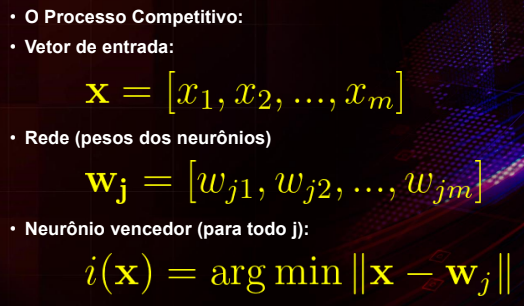

In [ ]:
display(Image('/content/competicao.png'))

- Cooperação: O neurônio vencedor, o BMU, determina a localização espacial de uma vizinhança topológica de neurônios excitados, fornecendo uma base para cooperação entre neurônios vizinhos.

    - O neurônio vencedor i(x), está no centro de uma região (vizinhança);
    - Neurônios vizinhos se beneficiam da ativação do neurônio vencedor, por isso estão excitados;
    - A definição da vizinhança topológica do neurônio vencedor é determinada pela proximidade através da função abaixo:





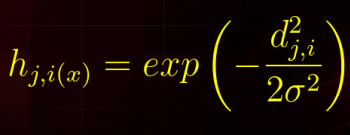

In [ ]:
display(Image('/content/cooperacao-funcao.png'))

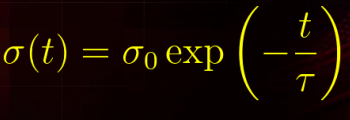

In [ ]:
display(Image('/content/decaimento-cooperacao.png'))

- Adaptação (Adaptação Sinaptática): Modificações nos pesos dos neurônios excitados de uma vizinhança topológica permitem que a função discriminante seja aplicada novamente nessa topologia para que o neurônio vencedor responda melhor ao padrão que o levou a ganhar a competição.

  - Para recalcular os pesos nos utilizamos:

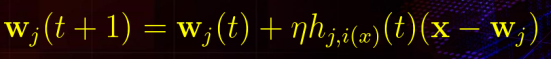

In [ ]:
# Exiba a imagem
display(Image('/content/adaptacao-sinaptica-funcao.png'))

  - Para calcular o decaimento, nós utilizamos:

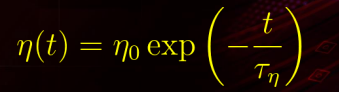

In [ ]:
display(Image('/content/adaptacao-sinaptica-decaimento.png'))

Assim, após repetidas apresentações de dados de treinamento, os pesos sinápticos tendem a seguir a distribuição do vetor de entrada devido a essa atualização sinapticas.

Sendo assim, o modelo leva a uma ordenação topológica do mapa de características em relação ao espaço de entrada.

Cada neurônio representa uma célula de Voronoi. É uma visão 2D de um espaço R^m. Neurônios próximos no grid tendem a responder padrões de ativação similares.

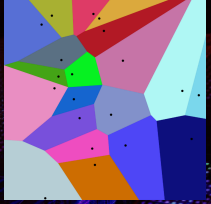

In [ ]:
display(Image('/content/represent-som.png'))

## Avaliação do Mapa

Com ou sem supervisão?

No caso de uma avaliação do mapa auto-organizável sem supervisão nós avaliamos:
- Erro de Quantização;
- Erro Topográfico;
- Inspeção Visual:
  - Heat Maps;
  - Hit Maps;
  - U-Matrix.

**Erro Topográfico:** Mede se os neurônios próximos no mapa estão mapeando dados que também são próximos no espaço original.

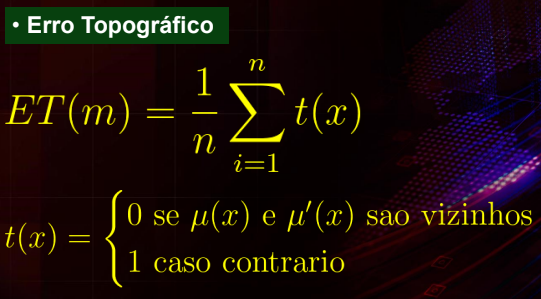

In [ ]:
display(Image('/content/erro-topog.png'))

**Erro de Quantização:** Mede a diferença dos padrões de entrada e o valor de seus neurônios vencedores.

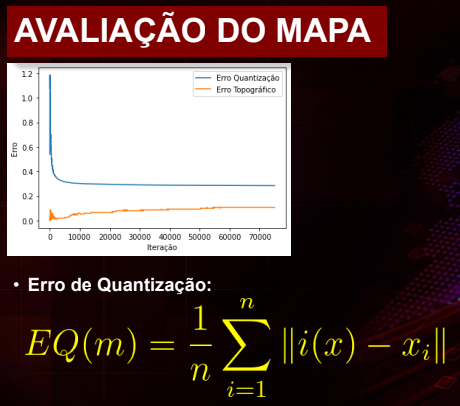

In [ ]:
display(Image('/content/erro-quanti.png'))

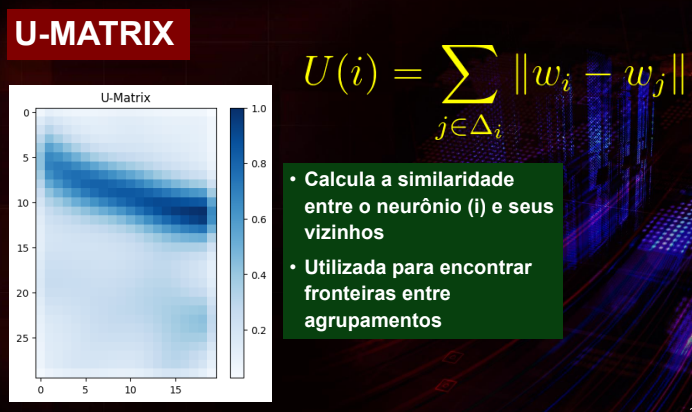

In [ ]:
display(Image('/content/u-matrix.png'))

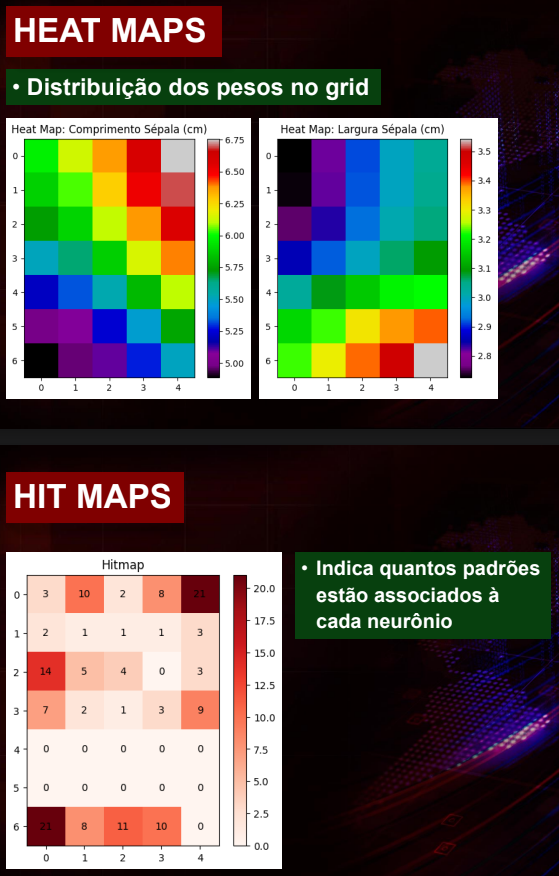

In [ ]:
display(Image('/content/insp-visu.png'))

Portanto, podemos concluir que o treinamento em uma rede SOM pode acontecer em duas fases:
- Organização/Ordenação Topológica;
- AJuste Fino (Convergência/Especialização).

Além disso, consideramos que há ajuste dinâmico na taxa de aprendizagem e na função (raio) de vizinhança.

# Conhecimento de Domínio

#### 1. Dataset MNIST
Inicialmente, usaremos um dataset MNIST, que possui dígitos manuscritos (28x28 pixels) transformados em vetores de 784 dimensões.

Essa abordagem com imagens é interessante, pois as SOMs podem realizar tarefa de agrupamento de imagens semelhantes em diferentes regiões do mapa, mostrando visualmente como as imagens são distribuídas no input space.

Fonte: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

In [ ]:
import kagglehub

# Download latest version
input_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", input_path)

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


#### 2. Dataset de Cores Aleatórias
Vamos realizar treinamento do modelo para um dataset de códigos RGB aleatórios a fim de atestar uma demonstração simples de uso.

# Análise Exploratória dos Dados


In [ ]:
!pip install minisom

In [ ]:
# all libs
from google.colab import files
from collections import Counter
from IPython.display import Image, display
from minisom import MiniSom
from pylab import plot, show, pcolor, colorbar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import struct
from array import array
from os.path  import join
from sklearn.metrics import silhouette_score

In [ ]:
#
# MNIST Data Loader Class
#

# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)

        # observe que aqui é criada a matriz 28x28 das imagens
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

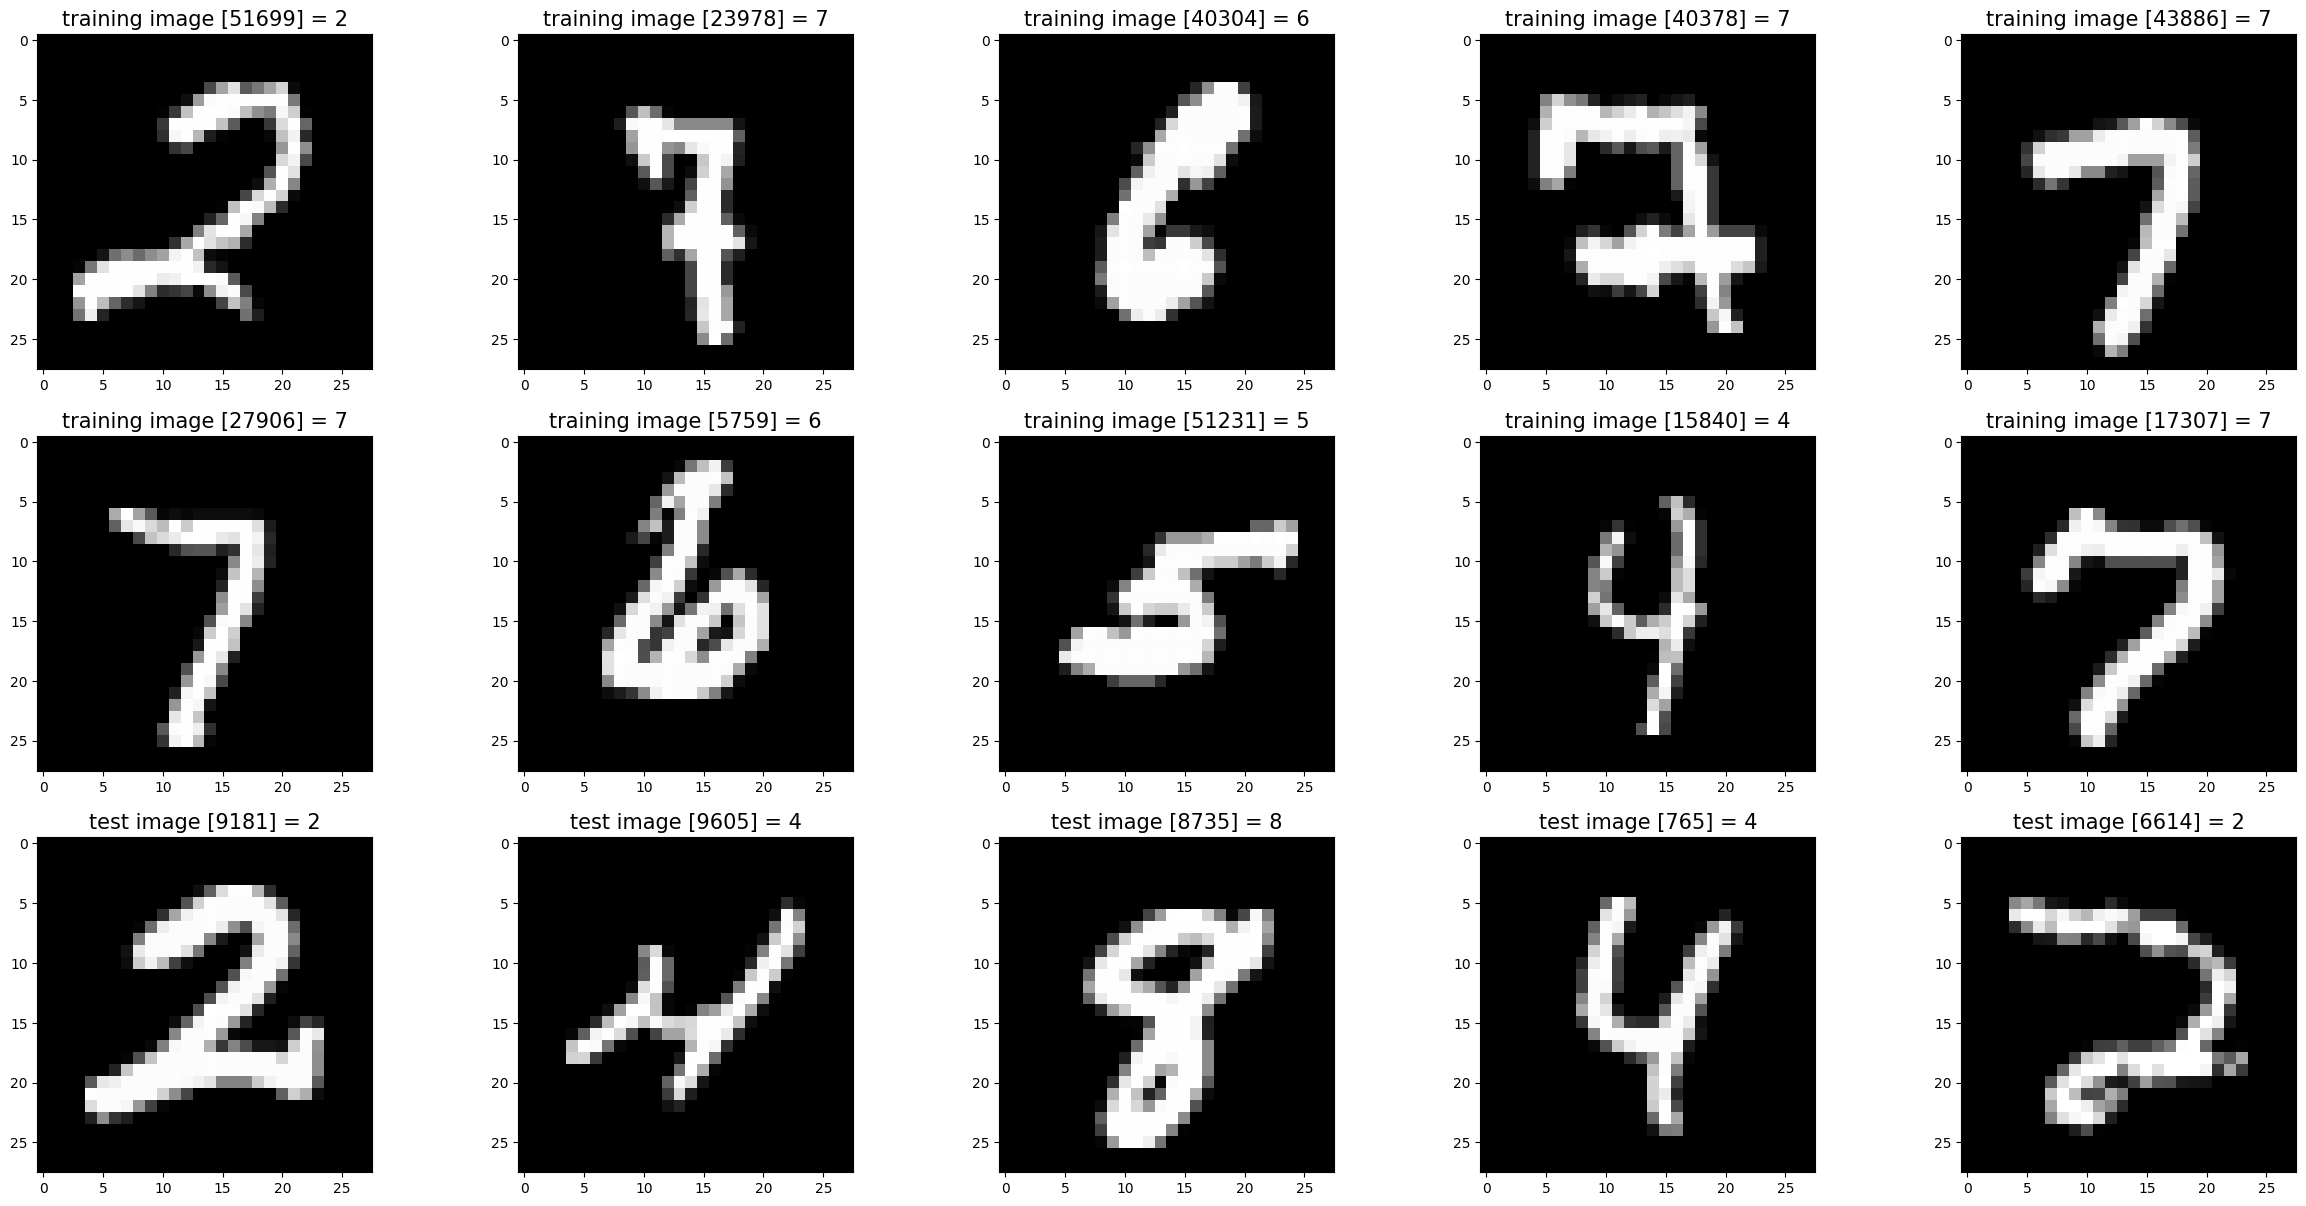

In [ ]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'list'>
<class 'array.array'>
<class 'list'>
<class 'array.array'>


Perceba que o código que carrega as imagens, fornecidas pelo Notebook do dataset nos prove a codificação das características das imagens em binário. Temos 28x28 = 784 pixels achatados em cada imagem, com a intensidade dos bits variando de 0 a 255, sendo 0 branco e 255 preto.

Em x_train e x_test nós temos cada nó como sendo uma matrix 28x28 (ou seja uma imagem).

Cada imagem deve ser armazenada como uma lista de 784 pixels para ser lida pela rede SOM.

In [ ]:
# Fazemos flattening (transformacao de uma matriz multidimensional em unidimensional)
# para dar entrada como vetor de características no modelo.
# Isso é necessário por que numa rede multilayer perceptron como a RNA Profunda SOM
# os dados recebidos em cada camada devem vir como um vetor de características e
# não em forma de matriz
x_train_flattened = [np.array(img).flatten() for img in x_train]
x_test_flattened = [np.array(img).flatten() for img in x_test]

# Normalizamos a lista de listas unidimensionais para que a rede trabalhe com
# valores binários. Dessa forma diminuimos a chance de overfitting.
# Como as imagens são preta e branca nós podemos fazer dessa forma:
x_train_normalized = np.array(x_train_flattened) / 255.0
x_test_normalized = np.array(x_test_flattened) / 255.0

In [ ]:
print(len(x_train_normalized), "imagens")
input_len = x_train_normalized.shape[1]
print(input_len, "pixels em cada imagem")

60000 imagens
784 pixels em cada imagem


In [ ]:
print(len(y_test), "labels")

10000 labels


# Extração de Padrões

In [ ]:
# Treinamento

# hiperparâmetros:
# - x e y:
#   - estabelecem a quantidade de neuronios em cada dimensao
#   - controlam a granularidade do SOM
#   - um SOM maior pode capturar mais detalhes, mas exige mais dados
#   e tempo de treinamento

# - input_len:
#   - numero de dimensoes dos dados de entrada
#   - deve corresponder ao numero de atributos de cada amostra

# - sigma:
#   - determina o tamanho inicial da vizinhança
#   - controla quantos neurônios ao redor do vencedor são atualizados em cada iteração
#   - normalmente diminui ao longo do treinamento

# - decay_function:
#   - define como o valor de sigma (e possivelmente da taxa de aprendizado)
#   decai ao longo das iterações. Por exemplo: uma função exponencial para
#   um sigma suave

# - learning_rate:
#   - taxa inicial de aprendizado

# - random_seed:
#   - semente para inicializar os pesos da SOM aleatoriamente, garantindo
#   reprodutibilidade dos resultados

# - neighborhood_function:
#   - função que define a forma como os neurônios vizinhos sofrem convergência
#   durante o treinamento

# - weights_init:
#   - inicializar os pesos dos neuronios

class SomModel():
  def __init__(self, x, y, input_len, sigma, learning_rate, topology, neighborhood_function):
    self.x = x
    self.y = y
    self.input_len = input_len
    self.sigma = sigma
    self.learning_rate = learning_rate
    self.topology = topology
    self.neighborhood_function = neighborhood_function

  def return_data(self):
    som = MiniSom(x=self.x, y=self.y, input_len=self.input_len, sigma=self.sigma,
                  learning_rate=self.learning_rate, topology=self.topology,
                  neighborhood_function=self.neighborhood_function)
    som.random_weights_init(x_train_normalized)

    # em cada iteração, o método seleciona uma amostra aleatória
    # para impedir que uma classe que se repete com maior frequência seja sempre
    # escolhida numa seleção aleatória simples, vamos utilizar som.train_batch
    # que itera sobre todo o conjunto de amostras e escolhe proporcionalmente
    # com base na classe
    som.train_batch(data=x_train_normalized, num_iteration=60000)

    # mapa autorganizavel para esse input
    pcolor(som.distance_map().T)  # Matriz de distâncias
    colorbar()
    show()

    return som

  def counter(self, som):
    # Obter os neurônios vencedores para cada amostra
    chosen_indices = [som.winner(x_train_normalized[i]) for i in range(len(x_train_normalized))]

    # Contar a frequência de cada neurônio
    counter = Counter(chosen_indices)

    # Separar as coordenadas dos neurônios e suas frequências
    neurons = list(counter.keys())
    frequencies = list(counter.values())

    # Converter os neurônios para coordenadas (x, y)
    x_coords, y_coords = zip(*neurons)

    # Plotar o histograma
    plt.figure(figsize=(10, 8))
    plt.scatter(x_coords, y_coords, s=np.array(frequencies) * 10, c=frequencies, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Frequência")
    plt.title("Distribuição de amostras nos neurônios vencedores")
    plt.xlabel("Coordenada X do neurônio")
    plt.ylabel("Coordenada Y do neurônio")
    plt.grid(True)
    plt.show()

    # Exibir os dados no console
    print("Distribuição das amostras por neurônio vencedor:")
    print(counter)

  def test_som(self, som, x_test_normalized):
    # Obter os neurônios vencedores para os dados de teste
    test_chosen_indices = [som.winner(x_test_normalized[i]) for i in range(len(x_test_normalized))]

    # Contar a frequência de cada neurônio para os dados de teste
    test_counter = Counter(test_chosen_indices)

    # Separar as coordenadas dos neurônios e suas frequências
    test_neurons = list(test_counter.keys())
    test_frequencies = list(test_counter.values())

    # Converter os neurônios para coordenadas (x, y)
    test_x_coords, test_y_coords = zip(*test_neurons)

    # Plotar o histograma dos dados de teste
    plt.figure(figsize=(10, 8))
    plt.scatter(test_x_coords, test_y_coords, s=np.array(test_frequencies) * 10, c=test_frequencies, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Frequência")
    plt.title("Distribuição de dados de teste nos neurônios vencedores")
    plt.xlabel("Coordenada X do neurônio")
    plt.ylabel("Coordenada Y do neurônio")
    plt.grid(True)
    plt.show()

    # Exibir os dados no console
    print("Distribuição dos dados de teste por neurônio vencedor:")
    print(test_counter)

  def evaluate_som(self, som, x_test_normalized, y_test=None):
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    from collections import defaultdict
    import numpy as np

    # Obter os neurônios vencedores para os dados de teste
    test_chosen_indices = [som.winner(x_test_normalized[i]) for i in range(len(x_test_normalized))]

    # Convertendo os índices de neurônios vencedores (x, y) para um único valor 1D
    grid_shape = som.get_weights().shape[:2]
    predicted_labels = [
        neuron[0] * grid_shape[1] + neuron[1] for neuron in test_chosen_indices
    ]

    if y_test is not None:
        # Agrupar os rótulos reais pelo neurônio vencedor
        clusters = defaultdict(list)
        for idx, label in enumerate(y_test):
            clusters[test_chosen_indices[idx]].append(label)

        # Imprimir os rótulos para cada neurônio vencedor
        print("Rótulos agrupados por neurônio vencedor:")
        for neuron, labels in clusters.items():
            print(f"Neurônio {neuron}: {labels}")

    # Avaliação interna baseada apenas nos clusters gerados
    x_test_flat = x_test_normalized.reshape(len(x_test_normalized), -1)  # Garantir entrada 2D

    try:
        silhouette_avg = silhouette_score(x_test_flat, predicted_labels)
        print(f"Silhouette Score: {silhouette_avg:.3f}")
    except Exception as e:
        print(f"Silhouette Score não pôde ser calculado: {e}")

    try:
        ch_score = calinski_harabasz_score(x_test_flat, predicted_labels)
        print(f"Calinski-Harabasz Score: {ch_score:.3f}")
    except Exception as e:
        print(f"Calinski-Harabasz Score não pôde ser calculado: {e}")

    try:
        db_score = davies_bouldin_score(x_test_flat, predicted_labels)
        print(f"Davies-Bouldin Score: {db_score:.3f}")
    except Exception as e:
        print(f"Davies-Bouldin Score não pôde ser calculado: {e}")

**Regra prática para escolha do número de neurônios no mapa:**
Número de neurônios = 5 * n^1/2

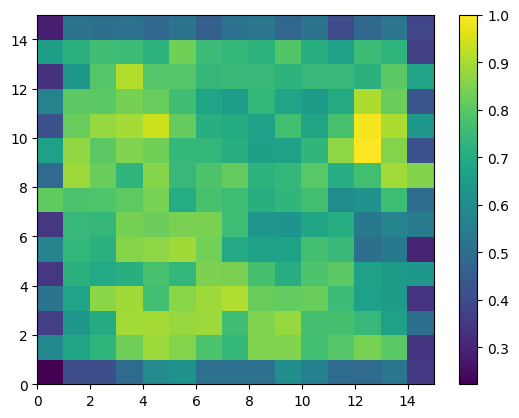

In [ ]:
som = SomModel(x=15, y=15, input_len=input_len, sigma=1.0, learning_rate=0.1,
               topology='hexagonal', neighborhood_function='gaussian')
n_som = som.return_data()

Observe a representação da ativação de neurônios no SOM. Para valores mais baixos de ativação temos a cor roxa, já para valores mais altos, temos a cor amarela.

Esses neurônios com maior frequência de ativação sugerem que houve maior adaptação sináptica para determinados padrões de ativação recorrentes

Acima temos uma representação visual um pouco diferente de frequência com que os neurônios foram capazes de serem ativados.

In [ ]:
# Detectamos neurônios outliers com base numa distância menor que 0.8
threshold = 0.8
distance_map = n_som.distance_map()
outliers = np.argwhere(distance_map < threshold)

print(f"Neurônios considerados outliers no treino (distância < {threshold}):")
print(outliers)

Neurônios considerados outliers no treino (distância < 0.8):
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 3  0]
 [ 3  4]
 [ 3  8]
 [ 3 13]
 [ 3 14]
 [ 4  0]
 [ 4  3]
 [ 4  4]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 5  0]
 [ 5  4]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 11]
 [ 5 12]
 [ 5 14]
 [ 6  0]
 [ 6  1]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 11]
 [ 6 12]
 [ 6 13]
 [ 6 14]
 [ 7  0]
 [ 7  1]
 [ 7  2]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 8  0]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 8 11]
 [ 8 12]
 [ 8 13]
 [ 8 14]
 [ 9  0]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]
 [ 9 13]
 [ 9 14]
 [10  0]
 [10  1]
 [10  2]
 [10  4]
 [1

# Avaliação

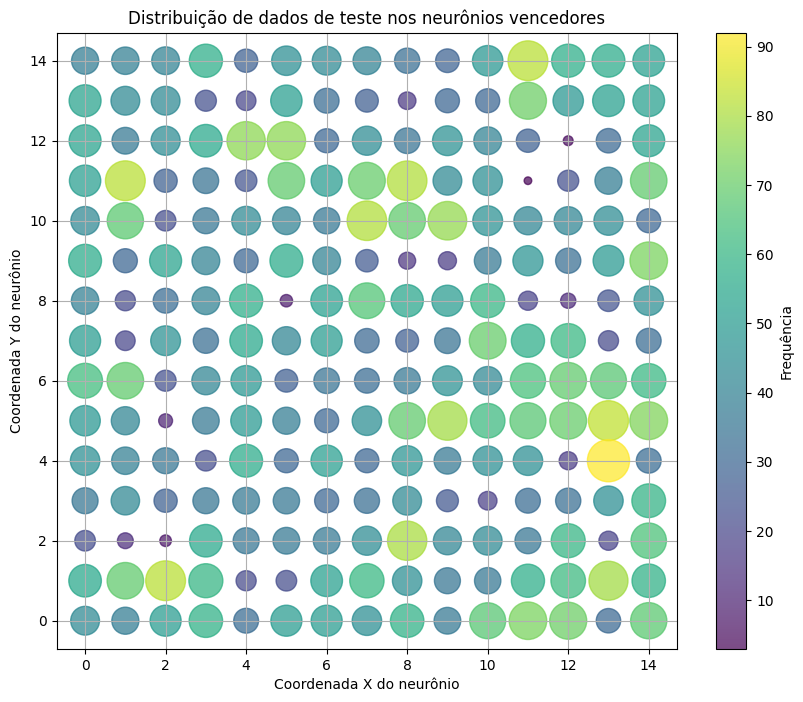

Distribuição dos dados de teste por neurônio vencedor:
Counter({(13, 4): 92, (13, 5): 83, (2, 1): 82, (1, 11): 82, (11, 14): 82, (8, 11): 81, (7, 10): 81, (8, 2): 80, (13, 1): 79, (9, 5): 79, (9, 10): 77, (5, 12): 76, (4, 12): 76, (14, 5): 74, (14, 9): 73, (11, 0): 73, (11, 13): 71, (12, 0): 71, (12, 5): 70, (7, 11): 70, (10, 7): 70, (14, 11): 69, (1, 1): 69, (1, 6): 69, (8, 5): 69, (8, 10): 69, (12, 6): 69, (5, 11): 69, (14, 0): 68, (1, 10): 68, (11, 5): 67, (13, 6): 67, (10, 0): 67, (7, 8): 66, (14, 2): 65, (11, 6): 64, (0, 6): 63, (12, 1): 62, (10, 5): 62, (12, 7): 61, (7, 1): 61, (14, 6): 61, (3, 1): 60, (12, 2): 60, (10, 8): 60, (14, 3): 59, (8, 0): 58, (14, 1): 58, (3, 0): 58, (3, 14): 57, (12, 14): 57, (11, 1): 57, (11, 7): 57, (4, 8): 57, (5, 9): 56, (4, 4): 56, (13, 14): 56, (0, 9): 56, (3, 12): 55, (3, 2): 55, (0, 1): 55, (4, 7): 55, (8, 8): 54, (0, 13): 53, (14, 12): 53, (0, 12): 53, (2, 9): 53, (14, 14): 52, (13, 13): 52, (6, 8): 52, (14, 13): 52, (6, 1): 52, (5, 13): 51, (

In [ ]:
# Realizar o teste com os dados normalizados
som.test_som(n_som, x_test_normalized)

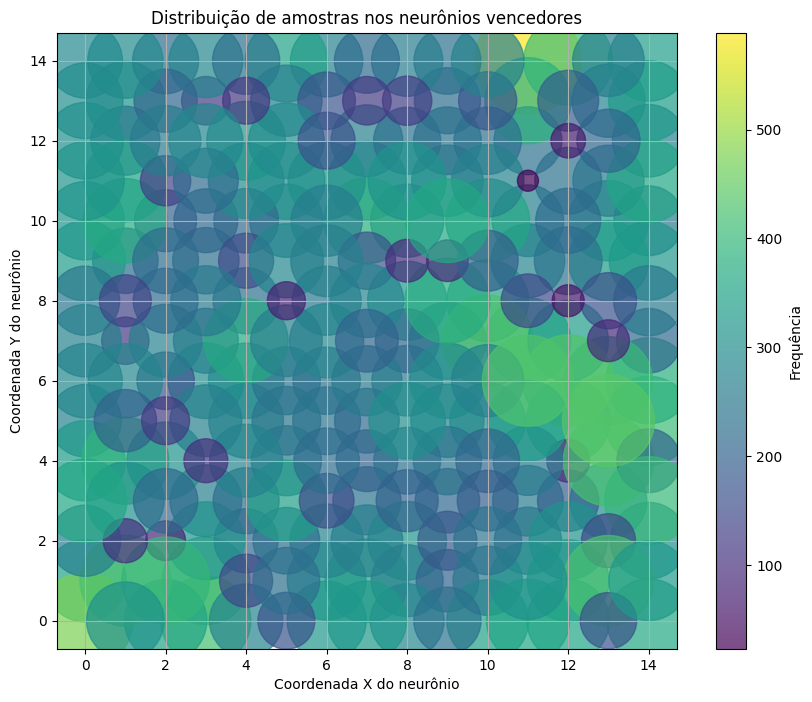

Distribuição das amostras por neurônio vencedor:
Counter({(11, 14): 589, (0, 0): 475, (13, 5): 439, (12, 6): 434, (10, 7): 431, (11, 6): 430, (1, 1): 428, (13, 1): 424, (13, 4): 422, (3, 0): 419, (12, 14): 410, (14, 5): 409, (13, 6): 404, (14, 3): 403, (3, 1): 399, (2, 1): 398, (1, 4): 391, (11, 13): 385, (14, 6): 382, (11, 7): 381, (7, 10): 381, (9, 8): 375, (1, 10): 369, (4, 7): 366, (12, 5): 365, (14, 0): 365, (10, 10): 363, (9, 10): 363, (0, 3): 361, (7, 1): 360, (14, 11): 358, (11, 0): 357, (12, 0): 353, (2, 0): 352, (1, 11): 352, (0, 1): 351, (5, 14): 351, (12, 1): 347, (10, 8): 346, (10, 0): 346, (5, 3): 341, (14, 14): 339, (11, 5): 337, (12, 7): 336, (0, 9): 335, (0, 4): 334, (13, 10): 334, (13, 9): 334, (14, 13): 333, (14, 1): 330, (7, 0): 326, (8, 8): 324, (6, 0): 324, (14, 9): 322, (1, 13): 321, (6, 1): 321, (4, 12): 321, (8, 2): 320, (7, 11): 320, (0, 10): 318, (0, 11): 318, (3, 2): 315, (8, 11): 315, (12, 2): 314, (1, 0): 312, (1, 3): 311, (11, 1): 311, (2, 4): 310, (5, 11

In [ ]:
som.counter(n_som)
som.evaluate_som(n_som, x_test_normalized, y_test=y_test)

Pensando em uma topologia hexagonal, podemos ter mais eficiência para o agrupamento de dados em comparação com a topologia retangular, pois oferece uma conectividade mais natural entre os neurônios, permitindo que o SOM aprenda representações mais coesas e precisas dos dados. A escolha de um sigma inicial maior permite que o SOM tenha uma maior influência sobre os vizinhos próximos no início, ajudando a capturar as características globais dos dados. Uma taxa de aprendizagem inicial mais alta acelera o processo de adaptação do SOM, permitindo que o modelo se ajuste rapidamente aos dados nos estágios iniciais.

Para nosso problema atual, o Silhouette Score de 0.036 é bem baixo, sugerindo que os clusters não estão sobrepostos. Acredito que ajustar o tamanho do mapa SOM, aumentar o número de iterações e ajustar os parâmetros sigma e a taxa de aprendizado possam ajudar no futuro. O Calinski-Harabasz Score de 48.869, embora não muito alto, indica alguma separação entre os clusters.

# Análise Exploratória dos Dados / Pré-Processamento


In [ ]:
#Training inputs for RGBcolors
colors = [
    # Tons de rosa (ordenados do mais forte ao mais claro)
    [0.78, 0.08, 0.52],  # Deep Pink
    [1.0, 0.43, 0.7],    # Hot Pink
    [0.87, 0.44, 0.63],  # Pale Violet Red
    [0.94, 0.5, 0.5],    # Salmon Pink
    [1.0, 0.75, 0.8],    # Light Pink

    # Tons de vermelho (ordenados do mais forte ao mais claro)
    [0.6, 0.0, 0.0],     # Red
    [0.7, 0.1, 0.1],     # Dark Red
    [0.5, 0.0, 0.0],     # Maroon
    [0.4, 0.0, 0.0],     # Dark Maroon
    [0.65, 0.0, 0.0],    # Indian Red
    [0.8, 0.2, 0.2],     # Firebrick
    [0.6, 0.0, 0.2],     # Chocolate Red
    [0.5, 0.0, 0.1],     # Dusty Red
    [0.8, 0.4, 0.4],     # Light Red
    [0.9, 0.6, 0.6],     # Pastel Red
]

data = np.array(colors)

# Extração de Padrões

In [ ]:
# Initializing and training the SOM
som = MiniSom(x=4, y=3, input_len=3, sigma=3.0, learning_rate=1.5, topology='rectangular', neighborhood_function='gaussian')

som.train(data, 10000, random_order=True, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.09882700160258225


In [ ]:
# Função para prever cores RGB
def predict_rgb_color(som, color):
    winner = som.winner(color)  # Encontra o neurônio vencedor para a cor
    return winner

# Função para prever uma lista de cores RGB
def predict_rgb_colors(som, colors_to_predict):
    predictions = []
    for color in colors_to_predict:
        winner = predict_rgb_color(som, color)
        predictions.append(winner)
    return predictions

# Exemplo de predição para novas cores
new_colors = [
    [0.75, 0.1, 0.5],  # Um tom de rosa
    [0.9, 0.2, 0.1],   # Um tom de vermelho
]

predicted_colors = predict_rgb_colors(som, new_colors)

# Exibo os neurônios vencedores para as cores preditas
print("Predições para as novas cores:")
for i, color in enumerate(new_colors):
    print(f"Cores RGB: {color} -> Neurônio vencedor: {predicted_colors[i]}")


Erro topográfico: 0.8000


In [ ]:
# Função para calcular o erro topográfico
def topographic_error(som, data):
    error_count = 0
    for sample in data:
        win_map = som.win_map(data)
        bmu1 = som.winner(sample)
        distances_map = som.distance_map()
        bmu2_coords = np.unravel_index(np.argsort(distances_map.flatten())[1], distances_map.shape)
        bmu2 = (bmu2_coords[0], bmu2_coords[1])
        dist = np.linalg.norm(np.array(bmu1) - np.array(bmu2))
        if dist > 1:  # Não são vizinhos
            error_count += 1
    return error_count / len(data)

error = topographic_error(som, data)
print(f'Erro topográfico: {error:.4f}')

# Avaliação

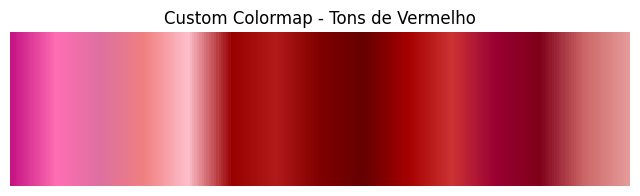

In [ ]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", data)
# Exibindo o colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect="auto", cmap=cmap)
plt.title("Custom Colormap - Tons de Vermelho")
plt.axis("off")
plt.show()

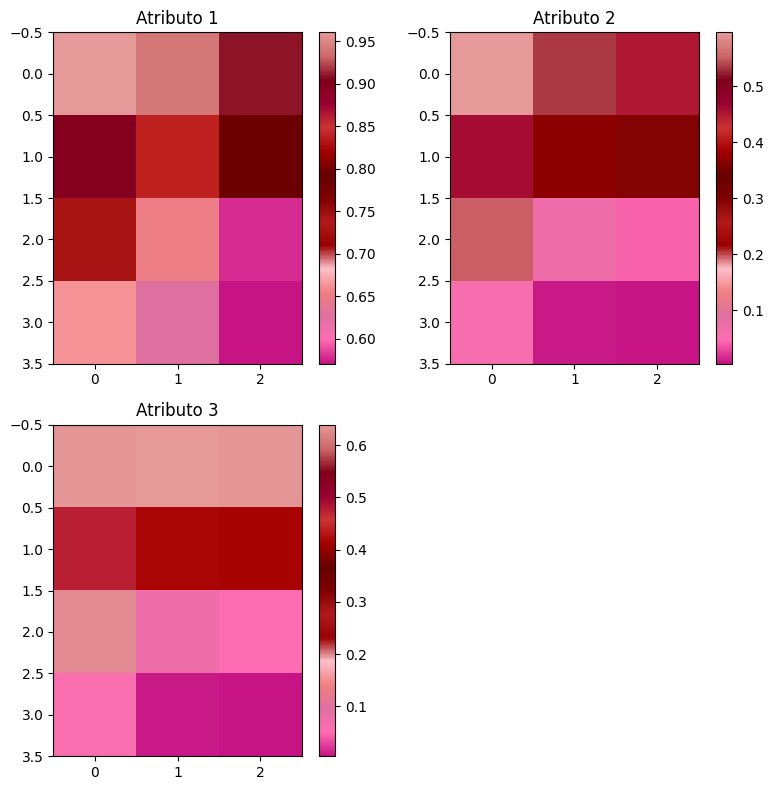

In [ ]:
# Criando um mapa de cores personalizado
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Heatmap para uma dimensão específica
plt.figure(figsize=(8, 8))

for i in range(3):  # Loop para cada atributo RGB
    plt.subplot(2, 2, i+1)

    # Obtenho os pesos do atributo i
    weights = som.get_weights()[:, :, i]

    # Exibindo o heatmap com o mapa de cores personalizado
    plt.imshow(weights, cmap=cmap, interpolation='none')
    plt.title(f'Atributo {i+1}')
    plt.colorbar()

plt.tight_layout()
plt.show()

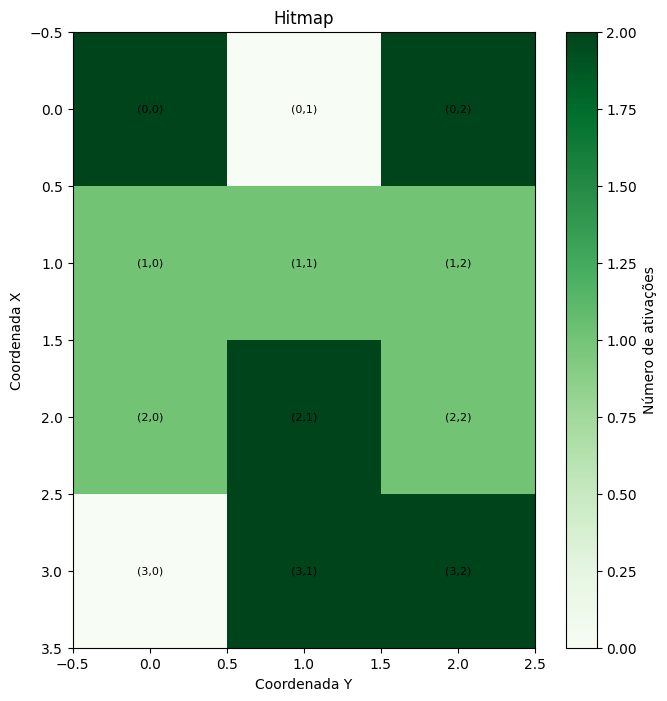

In [ ]:
# Hitmap - Nos mostra quais neuronios foram mais ativos para cada padrão
plt.figure(figsize=(8, 8))
frequencies = som.activation_response(data)  # Contagem de ativações
plt.imshow(frequencies, cmap='Greens', interpolation='none')
plt.colorbar(label='Número de ativações')
plt.title('Hitmap')

# Adicionando os índices dos neurônios
for x in range(frequencies.shape[0]):
    for y in range(frequencies.shape[1]):
        plt.text(y, x, f'({x},{y})', ha='center', va='center', fontsize=8, color='black')

plt.xlabel('Coordenada Y')
plt.ylabel('Coordenada X')
plt.show()

O desempenho do modelo SOM para o banco de dados RGB mostra um erro de quantização de 0.0988, o que indica que o modelo conseguiu representar bem as cores no mapa, com um erro médio relativamente baixo. No entanto, o erro topográfico de 0.8000 sugere que o mapa não está preservando bem as relações espaciais entre os dados, o que indica que a estrutura topológica não foi suficientemente capturada pelo modelo. Para melhorar o desempenho, seria interessante ajustar o valor de sigma e aumentar o número de iterações de treinamento, além de considerar o uso de um mapa maior para uma resolução mais precisa. Esses ajustes poderiam reduzir o erro topográfico e melhorar a fidelidade do modelo na representação das cores RGB, resultando em uma melhor preservação das características dos dados no mapa SOM.